# PyTCR - Example 2: Tropical cyclone rainfall generation

**Author:** [Phong Le](https://github.com/levuvietphong)

**Description:** This notebook demonstrates how to generate rainfall driven by tropical cyclones using track outputs from the statistical-dynamical [tropical cyclone downscaling model](https://github.com/linjonathan/tropical_cyclone_risk).

### Import libraries

In [1]:

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
import matplotlib.pyplot as plt

import cartopy.io.shapereader as shpreader
import cartopy.crs as ccrs
import colorcet as cc

import tcr.datadir as tcr_data
import tcr.rainfall as tcr_rain
import tcr.wind as tcr_wind
import tcr.iodata as tcr_io
import tcr.convert as tcr_convert
import tcr.plots as tcr_plot
import tcr.physics as tcr_physics

### Configuration for Mapping and Plotting

In [2]:
# Mapping boundary and projection
xmin = -115; xmax = -45
ymin = 12; ymax = 48
extent = [xmin, xmax, ymin, ymax]
projection = ccrs.AzimuthalEquidistant(central_longitude=-80, central_latitude=30)

# Shapefile for Continental US
fnCONUS = os.path.join(tcr_data.DATA_DIR, 'shapefiles', 'CONUS.shp')
shpCONUS = shpreader.Reader(fnCONUS)

# Plotting period
yearmin = 1964
yearmax = 2014
num_years = yearmax - yearmin + 1

# Directory containing the downscaled data
data_directory = os.path.join(tcr_data.DATA_DIR, 'downscaled')

### Load data from a CMIP6 model
In this notebook, the [E3SM version 1.0](https://e3sm.org/) is demonstrated but the notebook is applicable to other [CMIP6 models](https://pcmdi.llnl.gov/CMIP6/).
- Load tracks data from a CMIP6 model
- Estimate the translation speed of the tropical cyclones
- Convert datetime in model outputs to datetime in pandas

In [3]:
model = 'E3SM-1-0'
expmnt='historical'

# Load NetCDF data
ds, lat_trks, lon_trks, n_trks, v_trks, vmax_trks, u850_trks, v850_trks, \
    tc_month, tc_years, tc_time = tcr_io.load_netcdf_track_data(
    data_directory=data_directory, model=model, basin='NA', expmnt=expmnt)
    
# Currently, no secondary rain bands
ut, vt, jmax = tcr_wind.get_translation_speeds(lat_trks, lon_trks)

# Get datetime
date_trks = tcr_convert.to_datetime_from_netcdf(tc_years, tc_month, tc_time)    

### Estimate the radius of the tropical cyclone based on circular wind speed.
- The downscaling model does not provide the radius of maximum circular wind. We will estimate it using the wind speed only once and save it to the dataset.
- If the radius is already in the dataset, we will load it from file.

In [4]:
rm_trks = tcr_wind.estimate_radius_wind(
    ds, lat_trks, vmax_trks, n_trks, data_directory=data_directory, model=model,
    basin='NA', expmnt=expmnt, force_recompute=False
)

The radius of maximum circular wind was found in file!
Loading rm_trks...


### Calculate accumulated rain and rainrates at specified locations for the active event set
- Currently, the TC downscaling model doesn't include any secondary eyewall effect. We temporarily set the secondary maximum wind speed and radius to zero.
- We only consider TCs within 300 km from the POI. Tracks that do not cross this domain are excluded.

In [5]:
lat_poi = 29.97  # degree latitude
lon_poi = -94.01  # degree longitude (equivalent to 360-lon_poi degE)

# Note: temporarily ignore secondary eyewalls
rain, rainrate, dayk = tcr_rain.generate_rainfall_point(
    lat_poi, lon_poi, lat_trks, lon_trks, date_trks, v_trks, rm_trks,
    0*v_trks, 0*rm_trks, u850_trks, v850_trks, ut, vt, T600=None
)

# Remove tracks that do not cross the domain
poi_influence_zone = tcr_plot.create_buffer_around_POI(lat_poi, lon_poi, radius=2.5)
ind_mod = tcr_plot.get_tracks_landfall_region(lat_trks, lon_trks, poi_influence_zone, num_tracks=None)

rain_filtered_tracks = rain[ind_mod]
rainrate_filtered_tracks = rainrate[ind_mod,:,:,:]

#### Plot the accumulated rainfall over the hurricane period for the site POI

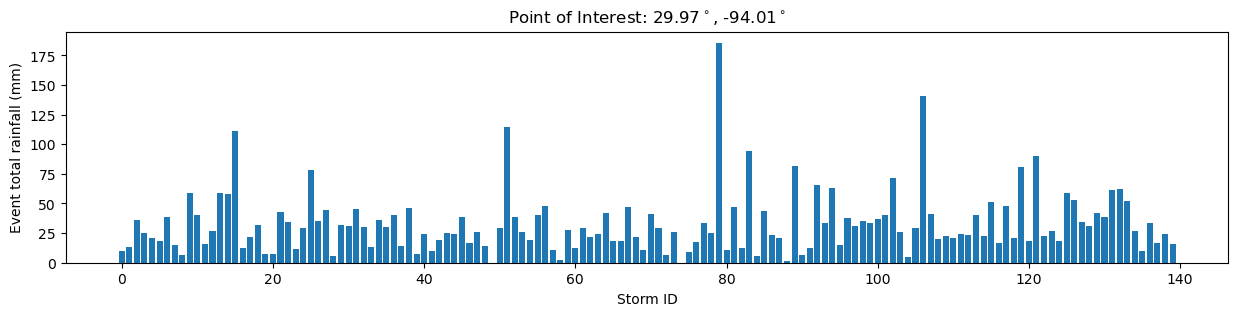

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(15, 3))
ax.bar(np.arange(len(rain_filtered_tracks)), rain_filtered_tracks)
ax.set_ylabel('Event total rainfall (mm)')
ax.set_xlabel('Storm ID')
ax.set_title(f'Point of Interest: {lat_poi}$^\circ$, {lon_poi}$^\circ$');

### Plot the Exceedance Probability of Event Total Rainfall (ETR)
- We remove all tropical cyclones that have no impact on the current POI (e.g. rain < 5 mm)

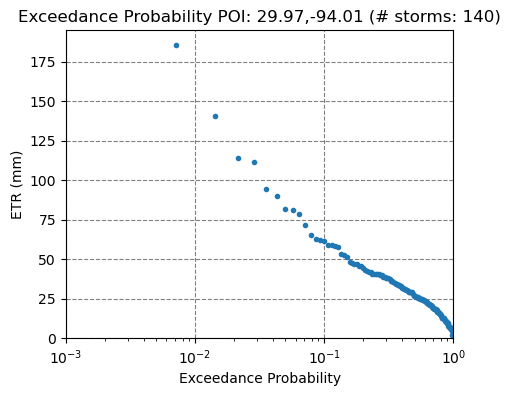

In [7]:
fig,ax = plt.subplots(1,1,figsize=(5,4))
tcr_plot.plot_exceedance_probability(
    rain_filtered_tracks, ax, ylabel="ETR (mm)", xlabel="Exceedance Probability",
    title=f"Exceedance Probability POI: {lat_poi},{lon_poi}")

### Plot the rainfall rate time series for random storms

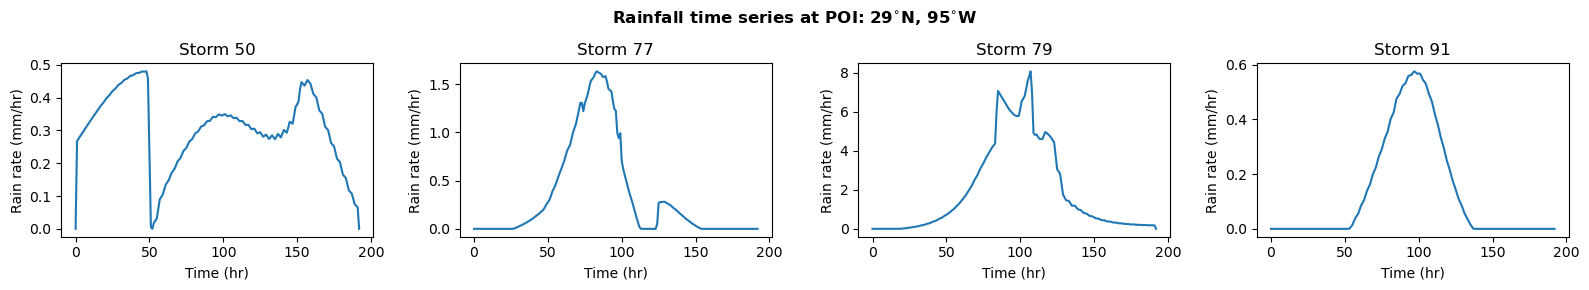

In [8]:
num_plots = 4
ind = np.sort(np.random.choice(len(rain_filtered_tracks), num_plots, replace=False))
fig, ax = plt.subplots(1, num_plots, figsize=(4*num_plots, 3))
for k in range(num_plots):
    ax[k].plot(np.squeeze(rainrate_filtered_tracks[ind[k], :]))
    ax[k].set_xlabel('Time (hr)')
    ax[k].set_ylabel('Rain rate (mm/hr)')
    ax[k].set_title(f'Storm {ind[k]}')
    # ax[k].set_ylim([-3, 20])
fig.suptitle('Rainfall time series at POI: 29$^{\circ}$N, 95$^{\circ}$W', 
             fontsize=12, fontweight='bold', y=0.95)
fig.tight_layout()

### Calculate the spatial distribution of accumulated precipitation for a given individual storm.

In [9]:
# Select (global) storm id
gl_storm_id = 527

# No secondary eyewall
x, y, netrain = tcr_rain.calculate_etr_swath(
    gl_storm_id, lat_trks, lon_trks, rm_trks, v_trks, 0*rm_trks, 0*v_trks, ut, vt, u850_trks, v850_trks
)

### Plot of spatial accumulated precipitation

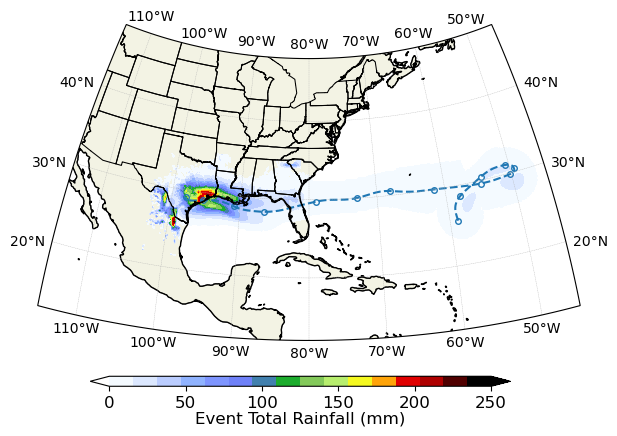

In [10]:
# Good 17 level colormap for precipitation
cmap = tcr_plot.load_cpt_colormap(os.path.join(tcr_data.DATA_DIR, 'colormaps', 'precip2_17lev.cpt'))
max_precip = 250
levels = np.linspace(0, max_precip, 17)
fig, ax = plt.subplots(1, 1, figsize=(7, 5), facecolor="w", subplot_kw=dict(projection=projection))

# PLOT Net Rainfall
netrain = np.ma.masked_where(netrain<1, netrain)
im = tcr_plot.plot_density(ax, y, x, netrain, levels, extent=extent, projection=projection,
                           alpha=1, cmap=cmap, gridlabel=True, shapefile=shpCONUS)

# Filter indices where lat_trks is not zero
valid_indices = lat_trks[gl_storm_id, :] != 0

ax.plot(lon_trks[gl_storm_id, valid_indices], lat_trks[gl_storm_id, valid_indices], color='tab:blue',
        ls='--', alpha=1, transform=ccrs.PlateCarree(), zorder=1)

# Show 15 dots along the track
ese = np.linspace(0, len(lon_trks[gl_storm_id, valid_indices]) - 1, 15, dtype=int)
ax.plot(lon_trks[gl_storm_id, ese], lat_trks[gl_storm_id, ese], 'o', ms=4, color='tab:blue',
        markerfacecolor='none', alpha=1, transform=ccrs.PlateCarree(), zorder=1)

# COLORBAR
cbax = fig.add_axes([0.2, 0.06, 0.6, 0.02])
cb = fig.colorbar(im, cax=cbax, orientation='horizontal')
cb.set_label(r'Event Total Rainfall (mm)', fontsize=12, labelpad=0)
cb.set_ticks(np.linspace(0, max_precip, 6))
cb.ax.tick_params(labelsize=12)

### Plot of spatial rainfall at a specific time step

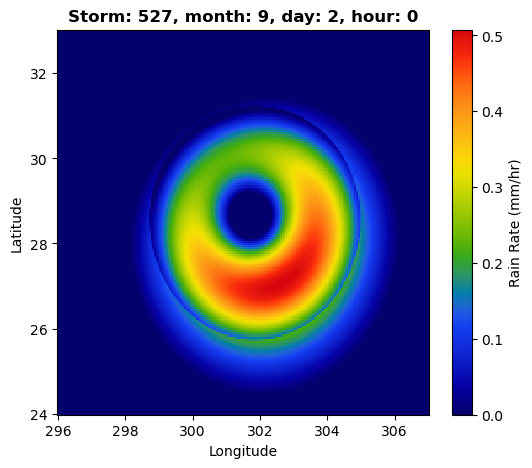

In [11]:

# Convert time to 2D arrays
num_storm = lat_trks.shape[0]
num_timestep = lat_trks.shape[1]

tc_month2d = np.tile(tc_month, (num_timestep, 1)).T
tc_hours2d = np.tile((tc_time / 3600) % 24, (num_storm, 1))
tc_days2d = np.tile(1+(tc_time / 3600) // 24, (num_storm, 1))

monthplot = int(tc_month[gl_storm_id])
dayplot = 2 # 1-15
hourplot = 0 # 0-23
rainrate, longstorm, latstorm = tcr_rain.calculate_rainfall_rate(
    gl_storm_id, lat_trks, lon_trks, rm_trks, v_trks, 0*rm_trks,0*v_trks, ut, vt, u850_trks, 
    v850_trks, tc_month2d, tc_days2d, tc_hours2d, monthplot, dayplot, hourplot)

fig, ax = plt.subplots(1,1,figsize=(6,5))
im = ax.pcolor(longstorm, latstorm, rainrate, cmap=cc.cm.CET_R4)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title(
    f"Storm: {gl_storm_id}, month: {monthplot}, day: {dayplot}, hour: {hourplot}",
    fontweight="bold",
)

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Rain Rate (mm/hr)')